<a href="https://colab.research.google.com/github/rafavidal1709/projeto-aplicado-iii/blob/main/Acur%C3%A1cia_dos_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregando o dataset de avaliação

Vamos conectar ao Google Drive para salvar e carregar arquivos permanentes.

Também vamos criar funções para lidar com o carregamento, armazenamento e transformação do dataset em seu formato original.

In [1]:
from google.colab import drive
import os
import json
from google.colab import files

drive.mount('/content/drive')

# Caminho para a pasta no Google Drive
folder_path = '/content/drive/MyDrive/projeto-aplicado-iii'

# Verificar se a pasta existe, se não, criar
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Faz o upload de um dataset
def upload_dataset():
  uploaded = files.upload()
  for file_name in uploaded.keys():
      with open(file_name, 'r', encoding='utf-8') as f:
          data = json.load(f)
  return data, file_name

# Formata o dataset original para o formato desejado
def format_dataset(data):
  dataset = {'text':[],'category':[],'embedding':{},'accuracy':{}}
  for c in range(len(data)):
    for i in data[c]['examples']:
      dataset['text'].append(i)
      dataset['category'].append(data[c]['category'])
  return dataset

# Salva o dataset no Google Drive
def save_dataset(dataset, filename):
  file_path = os.path.join(folder_path, filename+'.json')
  with open(file_path, 'w') as f:
    json.dump(dataset, f)

# Executa a sequência das três funções anteriores
def full_upload_dataset():
  data, file_name = upload_dataset()
  dataset = format_dataset(data)
  save_dataset(dataset,file_name)
  return dataset

# Carrega o dataset do Google Drive
def load_dataset(filename):
  file_path = os.path.join(folder_path, filename+'.json')
  with open(file_path, 'r') as f:
    data = json.load(f)
  if 'embedding' in data:
    data['embedding'] = {int(k): v for k, v in data['embedding'].items()}
  return data

Mounted at /content/drive


Se o dataset ainda não foi baixado e salvo no Google Drive:

In [ ]:
dataset = full_upload_dataset()

Saving Dataset 100 new.json to Dataset 100 new.json


OU se ele já está no formato correto no Google Drive:

In [2]:
dataset = load_dataset("dataset_accuracy")
dataset2 = load_dataset("dataset_accuracy_2")
accuracy = load_dataset("evaluate")
mask = load_dataset("mask")

Também pode salvá-lo no Google Drive:

In [ ]:
#save_dataset(dataset, "dataset_accuracy")
#save_dataset(dataset2, "dataset_accuracy_2")

# Embedding com Longformer

In [ ]:
import torch
from transformers import LongformerTokenizer, LongformerModel

class LongformerEmbedding:
  def __init__(self):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Verificar se a GPU está disponível
    torch.cuda.empty_cache()  # Liberar memória da GPU, se necessário
    self.tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-large-4096") # Carregar o modelo e o tokenizador Longformer-large
    self.model = LongformerModel.from_pretrained("allenai/longformer-large-4096").to(self.device)
    self.model.gradient_checkpointing_enable()  # Habilitar gradient checkpointing para economizar memória

  def process_text(self, text):
    with torch.no_grad():  # Desabilitar o cálculo de gradientes
        # Reduzir o comprimento máximo, se possível
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=2048)

        # Definir a máscara de atenção: 1 para global attention no primeiro token (ou outro token especial)
        attention_mask = torch.ones(inputs['input_ids'].shape, dtype=torch.long).to(self.device)  # Enviar para GPU
        global_attention_mask = torch.zeros(inputs['input_ids'].shape, dtype=torch.long).to(self.device)  # Enviar para GPU
        global_attention_mask[:, 0] = 1  # Dar atenção global ao primeiro token (posição 0)

        # Enviar os inputs para a GPU
        inputs = {key: value.to(self.device) for key, value in inputs.items()}

        # Passar pelo modelo com a máscara de atenção global
        outputs = self.model(input_ids=inputs['input_ids'], attention_mask=attention_mask, global_attention_mask=global_attention_mask)

        # Extraímos o embedding do primeiro token (com atenção global)
        global_attention_embedding = outputs.last_hidden_state[:, 0, :]  # Primeiro token com global attention

        # Fazer a média dos embeddings de todos os tokens (global pooling)
        output_mean_embedding = torch.mean(outputs.last_hidden_state, dim=1)

        # Mover os embeddings para a CPU
        global_attention_embedding = global_attention_embedding.cpu()
        output_mean_embedding = output_mean_embedding.cpu()

        # Sincronizar CUDA para garantir que a GPU terminou o processamento antes de prosseguir
        torch.cuda.synchronize()

        # Limpar variáveis não utilizadas e liberar memória da GPU
        del inputs, attention_mask, global_attention_mask, outputs
        torch.cuda.empty_cache()

        return {"longformer_global_attention": global_attention_embedding, "longformer_output_mean": output_mean_embedding}

longformer_embedding = LongformerEmbedding()
for i in range(len(dataset['text'])):
  embedding = longformer_embedding.process_text(dataset['text'][i])
  if i not in dataset['embedding']:
        dataset['embedding'][i] = {}
  for key, value in embedding.items():
    dataset['embedding'][i][key] = value.numpy().tolist()[0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/803 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

# Embedding com BERT

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

class BertEmbedding:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Verificar se a GPU está disponível
        torch.cuda.empty_cache()  # Liberar memória da GPU, se necessário
        self.tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")  # Carregar o modelo e o tokenizador BERT-large
        self.model = BertModel.from_pretrained("bert-large-uncased").to(self.device)

    def process_text(self, text):
        with torch.no_grad():  # Desabilitar o cálculo de gradientes
            # Reduzir o comprimento máximo, se possível
            inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)

            # Enviar os inputs para a GPU
            inputs = {key: value.to(self.device) for key, value in inputs.items()}

            # Passar pelo modelo
            outputs = self.model(**inputs)

            # Pooler output: já é o resumo global baseado no token [CLS]
            pooler_output = outputs.pooler_output.cpu()  # Já é um resumo do texto

            # Fazer a média dos embeddings de todos os tokens (global pooling)
            output_mean_embedding = torch.mean(outputs.last_hidden_state, dim=1)
            output_mean_embedding = output_mean_embedding.cpu()

            # Sincronizar CUDA para garantir que a GPU terminou o processamento antes de prosseguir
            torch.cuda.synchronize()

            # Limpar variáveis não utilizadas e liberar memória da GPU
            del inputs, outputs
            torch.cuda.empty_cache()

            return {"bert_pooler_output": pooler_output, "bert_output_mean": output_mean_embedding}

bert_embedding = BertEmbedding()
for i in range(len(dataset['text'])):
    embedding = bert_embedding.process_text(dataset['text'][i])
    if i not in dataset['embedding']:
        dataset['embedding'][i] = {}
    for key, value in embedding.items():
        dataset['embedding'][i][key] = value.numpy().tolist()[0]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

# Embedding com BERTimbau

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

class BertimbauEmbedding:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Verificar se a GPU está disponível
        torch.cuda.empty_cache()  # Liberar memória da GPU, se necessário
        self.tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-large-portuguese-cased")  # Carregar o modelo e o tokenizador BERTimbau-large
        self.model = BertModel.from_pretrained("neuralmind/bert-large-portuguese-cased").to(self.device)

    def process_text(self, text):
        with torch.no_grad():  # Desabilitar o cálculo de gradientes
            # Reduzir o comprimento máximo, se possível
            inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)

            # Enviar os inputs para a GPU
            inputs = {key: value.to(self.device) for key, value in inputs.items()}

            # Passar pelo modelo
            outputs = self.model(**inputs)

            # Pooler output: já é o resumo global baseado no token [CLS]
            pooler_output = outputs.pooler_output.cpu()  # Já é um resumo do texto

            # Fazer a média dos embeddings de todos os tokens (global pooling)
            output_mean_embedding = torch.mean(outputs.last_hidden_state, dim=1)
            output_mean_embedding = output_mean_embedding.cpu()

            # Sincronizar CUDA para garantir que a GPU terminou o processamento antes de prosseguir
            torch.cuda.synchronize()

            # Limpar variáveis não utilizadas e liberar memória da GPU
            del inputs, outputs
            torch.cuda.empty_cache()

            return {"bertimbau_pooler_output": pooler_output, "bertimbau_output_mean": output_mean_embedding}

bertimbau_embedding = BertimbauEmbedding()
for i in range(len(dataset['text'])):
    embedding = bertimbau_embedding.process_text(dataset['text'][i])
    if i not in dataset['embedding']:
        dataset['embedding'][i] = {}
    for key, value in embedding.items():
        dataset['embedding'][i][key] = value.numpy().tolist()[0]

tokenizer_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

# Métrica de acurácia

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def accuracy_test_cosine(dataset, embedding, top_n=8):
    # Inicializando a matriz de precisão com o shape (len(dataset['text']), top_n)
    accu_m = np.empty((len(dataset['text']), top_n))

    # Valor mínimo de acumulação
    min_accu = (top_n-1)*top_n/2

    embeddings = []
    for i in range(len(dataset['text'])):
        # Extraindo os embeddings correspondentes para o texto i
        embeddings.append(dataset['embedding'][i][embedding])

    for i in range(len(dataset['text'])):
        # Calculando similaridade cosseno entre o embedding atual e todos os outros embeddings
        similarities = cosine_similarity([embeddings[i]], embeddings)
        ranked_indices = np.argsort(similarities[0])[::-1]  # Ordenar por similaridade

        # Preenchendo a matriz de precisão
        n = 0
        for j in range(len(dataset['text'])):
            if dataset['category'][i] == dataset['category'][ranked_indices[j]]:
                accu_m[i][n] = j  # Salvando o índice da correspondência
                n += 1
            if n == top_n:
                break

    # Somando as linhas da matriz de precisão
    accu = np.sum(accu_m, axis=1).reshape(-1, 1)

    # Subtraindo o valor mínimo
    accu = accu - min_accu

    # Calculando precisão por categoria
    categories = list(set(dataset['category']))

    accu_mean = np.mean(accu)
    accu_per_cat = {}

    for category in categories:
        indices = np.where(np.array(dataset['category']) == category)
        accu_per_cat[category] = np.mean(accu[indices])  # Calcula a média para a categoria

    return {embedding: {"mean": accu_mean, "mean_per_cat": accu_per_cat, "matrix": accu_m.tolist()}}

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def accuracy_test_knn(dataset, embedding, top_n=8):
    # Inicializando a matriz de precisão com o shape (len(dataset['text']), top_n)
    accu_m = np.empty((len(dataset['text']), top_n))

    # Valor mínimo de acumulação
    min_accu = (top_n-1)*top_n/2

    embeddings = []
    for i in range(len(dataset['text'])):
        # Extraindo os embeddings correspondentes para o texto i
        embeddings.append(dataset['embedding'][i][embedding])

    # Convertendo a lista de embeddings para um array do numpy
    embeddings = np.array(embeddings)

    # Usando NearestNeighbors para calcular os k vizinhos mais próximos (k=top_n)
    knn = NearestNeighbors(n_neighbors=len(dataset['text']), metric='euclidean')
    knn.fit(embeddings)

    for i in range(len(dataset['text'])):
        # Encontrando os k vizinhos mais próximos para o embedding atual
        distances, ranked_indices = knn.kneighbors([embeddings[i]])

        # Preenchendo a matriz de precisão
        n = 0
        for j in range(len(dataset['text'])):  # Considerando apenas os top_n vizinhos
            if dataset['category'][i] == dataset['category'][ranked_indices[0][j]]:
                accu_m[i][n] = j  # Salvando o índice da correspondência
                n += 1
            if n == top_n:
                break

    # Somando as linhas da matriz de precisão
    accu = np.sum(accu_m, axis=1).reshape(-1, 1)

    # Subtraindo o valor mínimo
    accu = accu - min_accu

    # Calculando precisão por categoria
    categories = list(set(dataset['category']))

    accu_mean = np.mean(accu)
    accu_per_cat = {}

    for category in categories:
        indices = np.where(np.array(dataset['category']) == category)
        accu_per_cat[category] = np.mean(accu[indices])  # Calcula a média para a categoria

    return {embedding: {"mean": accu_mean, "mean_per_cat": accu_per_cat, "matrix": accu_m.tolist()}}

# Avaliação dos modelos



In [ ]:
dataset['accuracy']['cosine_similarity']={}
for emb in dataset['embedding'][0].keys():
  for key, value in accuracy_test_cosine(dataset, emb).items():
    dataset['accuracy']['cosine_similarity'][key] = value

display(dataset['accuracy']['cosine_similarity'])

{'longformer_global_attention': {'mean': 103.3,
  'mean_per_cat': {'queimadas': 92.5,
   'trabalhadores_sem_epi': 81.2,
   'pisoteamento_nascente': 116.25,
   'agrotoxico_proximo_residencias': 105.3,
   'contaminacao_nascente_agrotoxico': 121.25},
  'matrix': [[0.0, 1.0, 2.0, 7.0, 8.0, 10.0, 12.0, 15.0],
   [0.0, 2.0, 3.0, 6.0, 8.0, 12.0, 13.0, 14.0],
   [0.0, 7.0, 22.0, 25.0, 30.0, 36.0, 39.0, 47.0],
   [0.0, 2.0, 3.0, 5.0, 11.0, 13.0, 15.0, 16.0],
   [0.0, 8.0, 19.0, 24.0, 34.0, 43.0, 51.0, 63.0],
   [0.0, 20.0, 29.0, 47.0, 50.0, 57.0, 63.0, 69.0],
   [0.0, 2.0, 7.0, 11.0, 13.0, 14.0, 15.0, 19.0],
   [0.0, 1.0, 4.0, 6.0, 8.0, 11.0, 14.0, 15.0],
   [0.0, 2.0, 4.0, 5.0, 7.0, 12.0, 16.0, 18.0],
   [0.0, 5.0, 10.0, 11.0, 12.0, 14.0, 18.0, 24.0],
   [0.0, 4.0, 7.0, 9.0, 11.0, 13.0, 16.0, 17.0],
   [0.0, 3.0, 6.0, 11.0, 13.0, 14.0, 15.0, 19.0],
   [0.0, 3.0, 8.0, 9.0, 11.0, 12.0, 15.0, 16.0],
   [0.0, 3.0, 14.0, 19.0, 27.0, 30.0, 35.0, 39.0],
   [0.0, 6.0, 7.0, 10.0, 11.0, 14.0, 20.0, 25.0

In [ ]:
dataset['accuracy']['knn_euclidian']={}
for emb in dataset['embedding'][0].keys():
  for key, value in accuracy_test_knn(dataset, emb).items():
    dataset['accuracy']['knn_euclidian'][key] = value

display(dataset['accuracy']['knn_euclidian'])

{'longformer_global_attention': {'mean': 103.3,
  'mean_per_cat': {'queimadas': 92.5,
   'trabalhadores_sem_epi': 81.2,
   'pisoteamento_nascente': 116.25,
   'agrotoxico_proximo_residencias': 105.3,
   'contaminacao_nascente_agrotoxico': 121.25},
  'matrix': [[0.0, 1.0, 2.0, 7.0, 8.0, 10.0, 12.0, 15.0],
   [0.0, 2.0, 3.0, 6.0, 8.0, 12.0, 13.0, 14.0],
   [0.0, 7.0, 22.0, 25.0, 30.0, 36.0, 39.0, 47.0],
   [0.0, 2.0, 3.0, 5.0, 11.0, 13.0, 15.0, 16.0],
   [0.0, 8.0, 19.0, 24.0, 34.0, 43.0, 51.0, 63.0],
   [0.0, 20.0, 29.0, 47.0, 50.0, 57.0, 63.0, 69.0],
   [0.0, 2.0, 7.0, 11.0, 13.0, 14.0, 15.0, 19.0],
   [0.0, 1.0, 4.0, 6.0, 8.0, 11.0, 14.0, 15.0],
   [0.0, 2.0, 4.0, 5.0, 7.0, 12.0, 16.0, 18.0],
   [0.0, 5.0, 10.0, 11.0, 12.0, 14.0, 18.0, 24.0],
   [0.0, 4.0, 7.0, 9.0, 11.0, 13.0, 16.0, 17.0],
   [0.0, 3.0, 6.0, 11.0, 13.0, 14.0, 15.0, 19.0],
   [0.0, 3.0, 8.0, 9.0, 11.0, 12.0, 15.0, 16.0],
   [0.0, 3.0, 14.0, 19.0, 27.0, 30.0, 35.0, 39.0],
   [0.0, 6.0, 7.0, 10.0, 11.0, 14.0, 20.0, 25.0

# Métrica de acurácia 2

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def accuracy2_test_cosine(dataset, dataset2, embedding, top_n=8):
    # Inicializando a matriz de precisão com o shape (len(dataset['text']), top_n)
    accu_m = np.empty((len(dataset2['text']), top_n))

    # Valor mínimo de acumulação
    min_accu = (top_n-1)*top_n/2

    embeddings = []
    for i in range(len(dataset['text'])):
        # Extraindo os embeddings correspondentes para o texto i
        embeddings.append(dataset['embedding'][i][embedding])

    embeddings2 = []
    for i in range(len(dataset2['text'])):
        # Extraindo os embeddings correspondentes para o texto i
        embeddings2.append(dataset2['embedding'][i][embedding])

    for i in range(len(dataset2['text'])):
        # Calculando similaridade cosseno entre o embedding atual e todos os outros embeddings
        similarities = cosine_similarity([embeddings2[i]], embeddings)
        ranked_indices = np.argsort(similarities[0])[::-1]  # Ordenar por similaridade

        # Preenchendo a matriz de precisão
        n = 0
        for j in range(len(dataset['text'])):
            if dataset2['category'][i] == dataset['category'][ranked_indices[j]]:
                accu_m[i][n] = j  # Salvando o índice da correspondência
                n += 1
            if n == top_n:
                break

    # Somando as linhas da matriz de precisão
    accu = np.sum(accu_m, axis=1).reshape(-1, 1)

    # Subtraindo o valor mínimo
    accu = accu - min_accu

    # Calculando precisão por categoria
    categories = list(set(dataset2['category']))

    accu_mean = np.mean(accu)
    accu_per_cat = {}

    for category in categories:
        indices = np.where(np.array(dataset2['category']) == category)
        accu_per_cat[category] = np.mean(accu[indices])  # Calcula a média para a categoria

    return {embedding: {"mean": accu_mean, "mean_per_cat": accu_per_cat, "matrix": accu_m.tolist()}}

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def accuracy2_test_knn(dataset, dataset2, embedding, top_n=8):
    # Inicializando a matriz de precisão com o shape (len(dataset['text']), top_n)
    accu_m = np.empty((len(dataset2['text']), top_n))

    # Valor mínimo de acumulação
    min_accu = (top_n-1)*top_n/2

    embeddings = []
    for i in range(len(dataset['text'])):
        # Extraindo os embeddings correspondentes para o texto i
        embeddings.append(dataset['embedding'][i][embedding])

    # Convertendo a lista de embeddings para um array do numpy
    embeddings = np.array(embeddings)

    embeddings2 = []
    for i in range(len(dataset2['text'])):
        # Extraindo os embeddings correspondentes para o texto i
        embeddings2.append(dataset2['embedding'][i][embedding])

    # Convertendo a lista de embeddings para um array do numpy
    embeddings2 = np.array(embeddings2)

    # Usando NearestNeighbors para calcular os k vizinhos mais próximos (k=top_n)
    knn = NearestNeighbors(n_neighbors=len(dataset['text']), metric='euclidean')
    knn.fit(embeddings)

    for i in range(len(dataset2['text'])):
        # Encontrando os k vizinhos mais próximos para o embedding atual
        distances, ranked_indices = knn.kneighbors([embeddings2[i]])

        # Preenchendo a matriz de precisão
        n = 0
        for j in range(len(dataset['text'])):  # Considerando apenas os top_n vizinhos
            if dataset['category'][i] == dataset['category'][ranked_indices[0][j]]:
                accu_m[i][n] = j  # Salvando o índice da correspondência
                n += 1
            if n == top_n:
                break

    # Somando as linhas da matriz de precisão
    accu = np.sum(accu_m, axis=1).reshape(-1, 1)

    # Subtraindo o valor mínimo
    accu = accu - min_accu

    # Calculando precisão por categoria
    categories = list(set(dataset2['category']))

    accu_mean = np.mean(accu)
    accu_per_cat = {}

    for category in categories:
        indices = np.where(np.array(dataset2['category']) == category)
        accu_per_cat[category] = np.mean(accu[indices])  # Calcula a média para a categoria

    return {embedding: {"mean": accu_mean, "mean_per_cat": accu_per_cat, "matrix": accu_m.tolist()}}

# Avaliação dos modelos 2

In [ ]:
dataset2['accuracy']['cosine_similarity']={}
for emb in dataset2['embedding'][0].keys():
  for key, value in accuracy2_test_cosine(dataset, dataset2, emb).items():
    dataset2['accuracy']['cosine_similarity'][key] = value

display(dataset2['accuracy']['cosine_similarity'])

{'longformer_global_attention': {'mean': 153.52,
  'mean_per_cat': {'queimadas': 93.4,
   'trabalhadores_sem_epi': 141.6,
   'pisoteamento_nascente': 125.3,
   'agrotoxico_proximo_residencias': 210.5,
   'contaminacao_agua_agrotoxico': 196.8},
  'matrix': [[6.0, 8.0, 29.0, 36.0, 42.0, 49.0, 54.0, 63.0],
   [8.0, 20.0, 31.0, 42.0, 53.0, 57.0, 60.0, 67.0],
   [0.0, 3.0, 4.0, 11.0, 13.0, 14.0, 15.0, 19.0],
   [1.0, 7.0, 14.0, 16.0, 23.0, 26.0, 28.0, 32.0],
   [7.0, 9.0, 11.0, 31.0, 44.0, 47.0, 53.0, 66.0],
   [3.0, 5.0, 8.0, 20.0, 23.0, 24.0, 32.0, 37.0],
   [2.0, 25.0, 30.0, 34.0, 45.0, 53.0, 60.0, 68.0],
   [1.0, 22.0, 26.0, 35.0, 48.0, 55.0, 60.0, 68.0],
   [1.0, 14.0, 34.0, 35.0, 52.0, 54.0, 59.0, 68.0],
   [8.0, 10.0, 11.0, 20.0, 24.0, 25.0, 26.0, 41.0],
   [17.0, 18.0, 22.0, 26.0, 46.0, 48.0, 49.0, 53.0],
   [12.0, 20.0, 38.0, 39.0, 41.0, 43.0, 46.0, 48.0],
   [8.0, 30.0, 35.0, 37.0, 39.0, 44.0, 48.0, 51.0],
   [1.0, 3.0, 8.0, 17.0, 19.0, 29.0, 31.0, 36.0],
   [0.0, 6.0, 24.0, 26.0,

In [ ]:
dataset2['accuracy']['knn_euclidian']={}
for emb in dataset2['embedding'][0].keys():
  for key, value in accuracy2_test_knn(dataset, dataset2, emb).items():
    dataset2['accuracy']['knn_euclidian'][key] = value

display(dataset2['accuracy']['knn_euclidian'])

{'longformer_global_attention': {'mean': 187.16,
  'mean_per_cat': {'queimadas': 196.6,
   'trabalhadores_sem_epi': 128.6,
   'pisoteamento_nascente': 188.8,
   'agrotoxico_proximo_residencias': 210.6,
   'contaminacao_agua_agrotoxico': 211.2},
  'matrix': [[6.0, 8.0, 29.0, 36.0, 42.0, 49.0, 54.0, 63.0],
   [8.0, 20.0, 31.0, 42.0, 53.0, 57.0, 60.0, 67.0],
   [0.0, 3.0, 4.0, 11.0, 13.0, 14.0, 15.0, 19.0],
   [1.0, 7.0, 14.0, 16.0, 23.0, 26.0, 28.0, 32.0],
   [7.0, 9.0, 11.0, 31.0, 44.0, 47.0, 53.0, 66.0],
   [3.0, 5.0, 8.0, 20.0, 23.0, 25.0, 32.0, 37.0],
   [2.0, 25.0, 30.0, 34.0, 45.0, 53.0, 60.0, 68.0],
   [1.0, 22.0, 26.0, 35.0, 48.0, 55.0, 60.0, 68.0],
   [1.0, 14.0, 34.0, 35.0, 52.0, 54.0, 59.0, 68.0],
   [8.0, 10.0, 11.0, 20.0, 24.0, 25.0, 26.0, 41.0],
   [4.0, 19.0, 27.0, 39.0, 44.0, 52.0, 61.0, 68.0],
   [3.0, 13.0, 30.0, 31.0, 36.0, 53.0, 61.0, 68.0],
   [3.0, 24.0, 28.0, 36.0, 41.0, 53.0, 61.0, 68.0],
   [0.0, 6.0, 7.0, 9.0, 10.0, 12.0, 15.0, 20.0],
   [5.0, 7.0, 18.0, 29.0, 3

In [ ]:
for n in range(len(dataset2['text'])):
  print(dataset2['category'][n]," : ",dataset2['text'][n])
  print(dataset2['accuracy']['cosine_similarity']['bertimbau_pooler_output']['matrix'][n])
  print(dataset2['accuracy']['cosine_similarity']['bertimbau_output_mean']['matrix'][n])

agrotoxico_proximo_residencias  :  Vi o Seu José espalhando veneno na plantação, bem perto da escola lá na subida do Morro da Lua.
[0.0, 2.0, 3.0, 4.0, 9.0, 13.0, 15.0, 18.0]
[1.0, 2.0, 3.0, 6.0, 8.0, 9.0, 10.0, 16.0]
agrotoxico_proximo_residencias  :  O João do Sítio aplicou defensivo na lavoura e o vento trouxe o cheiro forte até as casas perto da praça central.
[3.0, 6.0, 11.0, 14.0, 24.0, 38.0, 60.0, 64.0]
[0.0, 14.0, 23.0, 26.0, 27.0, 30.0, 31.0, 34.0]
agrotoxico_proximo_residencias  :  Dona Maria do Vale Encantado jogou agrotóxico e afetou a vizinhança aqui perto.
[1.0, 2.0, 6.0, 7.0, 10.0, 11.0, 12.0, 14.0]
[0.0, 1.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0]
agrotoxico_proximo_residencias  :  Ontem vi o Carlos usando pesticida na fazenda ao lado da trilha perto de casa, tá tudo contaminado.
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 8.0, 10.0]
[0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 10.0]
agrotoxico_proximo_residencias  :  O Paulo, da fazenda perto do Pico do Gavião, pulverizou veneno e as casas próximas 

# Predição

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import numpy as np

def predict_cosine(base_dataset, dataset, embedding, top_n=5, repeat=1, mask=None):
    base_embeddings = []
    for i in range(len(base_dataset['text'])):
        # Extraindo os embeddings correspondentes para o texto i
        base_embeddings.append(base_dataset['embedding'][i][embedding])

    embeddings = []
    for i in range(len(dataset['text'])):
        # Extraindo os embeddings correspondentes para o texto i
        embeddings.append(dataset['embedding'][i][embedding])

    if mask is not None:
        base_embeddings = [[b * m for b, m in zip(sublist, mask)] for sublist in base_embeddings]
        embeddings = [[e * m for e, m in zip(sublist, mask)] for sublist in embeddings]

    tags = []

    for i in range(len(dataset['text'])):
        # Calculando similaridade cosseno entre o embedding atual e todos os outros embeddings
        similarities = cosine_similarity([embeddings[i]], base_embeddings)
        ranked_indices = np.argsort(similarities[0])[::-1]  # Ordenar por similaridade

        tags_ = {}
        for j in range(top_n):
            if base_dataset['category'][ranked_indices[j]] in tags_:
                tags_[base_dataset['category'][ranked_indices[j]]] += 1
            else:
                tags_[base_dataset['category'][ranked_indices[j]]] = 1

        tags.append([])
        for rep in range(repeat, 0, -1):
          for key, value in tags_.items():
            if value >= rep:
              tags[i].append(key)
          if len(tags[i]) > 0:
            break;

    return tags

def predict_knn(base_dataset, dataset, embedding, top_n=5, repeat=1, mask=None):
    base_embeddings = []
    for i in range(len(base_dataset['text'])):
        # Extraindo os embeddings correspondentes para o texto i
        base_embeddings.append(base_dataset['embedding'][i][embedding])

    embeddings = []
    for i in range(len(dataset['text'])):
        # Extraindo os embeddings correspondentes para o texto i
        embeddings.append(dataset['embedding'][i][embedding])

    # Convertendo a lista de embeddings para um array do numpy
    base_embeddings = np.array(base_embeddings)
    embeddings = np.array(embeddings)

    if mask is not None:
        base_embeddings *= mask
        embeddings *= mask

    # Usando NearestNeighbors para calcular os k vizinhos mais próximos (k=top_n)
    knn = NearestNeighbors(n_neighbors=top_n, metric='euclidean')
    knn.fit(base_embeddings)

    tags = []
    for i in range(len(dataset['text'])):
        # Encontrando os k vizinhos mais próximos para o embedding atual
        distances, ranked_indices = knn.kneighbors([embeddings[i]])

        tags_ = {}
        for j in range(top_n):
            if base_dataset['category'][ranked_indices[0][j]] in tags_:
                tags_[base_dataset['category'][ranked_indices[0][j]]] += 1
            else:
                tags_[base_dataset['category'][ranked_indices[0][j]]] = 1

        tags.append([])
        for rep in range(repeat, 0, -1):
          for key, value in tags_.items():
            if value >= rep:
              tags[i].append(key)
          if len(tags[i]) > 0:
            break;

    return tags

def predict(base_dataset, dataset, method, embedding, top_n=5, repeat=1, mask=None):
  if method == 'cosine':
    return predict_cosine(base_dataset, dataset, embedding, top_n, repeat, mask)
  elif method == 'knn':
    return predict_knn(base_dataset, dataset, embedding, top_n, repeat, mask)

def evaluate(base_dataset, dataset, method, embedding, top_n=5, repeat=1, mask=None):
  tags = predict(base_dataset, dataset, method, embedding, top_n, repeat, mask)
  accu = 0
  for i in range(len(dataset['text'])):
    a = 0
    for t in tags[i]:
      if t in dataset['category'][i]:
        a += 1
    if len(tags[i])>0:
      accu += a/len(tags[i])
  return accu/len(dataset['text'])

print(evaluate(dataset, dataset2, 'cosine', 'bertimbau_output_mean', top_n=9, repeat=5, mask=mask['bertimbau_output_mean']['mask']))
print(evaluate(dataset, dataset2, 'knn', 'bertimbau_output_mean', top_n=10, repeat=5, mask=mask['bertimbau_output_mean']['mask']))

0.6233333333333333
0.68


In [ ]:
import time

accuracy = []

for method in ['cosine', 'knn']:
  for embedding in dataset['embedding'][0].keys():
    start_time = time.time()
    for top_n in range(1, 21):
      for repeat in range(1, top_n+1):
        accuracy.append({'method':method, 'embedding':embedding, 'top_n':top_n, 'repeat':repeat, 'accuracy':evaluate(dataset, dataset2, method, embedding, top_n, repeat)})
    print(method, ' ', embedding, ' ', time.time() - start_time, ' segundos')

print(accuracy)
save_dataset(accuracy,'evaluate')

cosine   longformer_global_attention   166.4158582687378  segundos
cosine   longformer_output_mean   157.05584383010864  segundos
cosine   bert_pooler_output   158.97720575332642  segundos
cosine   bert_output_mean   158.19655919075012  segundos
cosine   bertimbau_pooler_output   157.19191813468933  segundos
cosine   bertimbau_output_mean   157.75371551513672  segundos
knn   longformer_global_attention   7.319144010543823  segundos
knn   longformer_output_mean   7.562362432479858  segundos
knn   bert_pooler_output   7.553481817245483  segundos
knn   bert_output_mean   7.430881023406982  segundos
knn   bertimbau_pooler_output   8.965566396713257  segundos
knn   bertimbau_output_mean   8.050276517868042  segundos
[{'method': 'cosine', 'embedding': 'longformer_global_attention', 'top_n': 1, 'repeat': 1, 'accuracy': 0.28}, {'method': 'cosine', 'embedding': 'longformer_global_attention', 'top_n': 2, 'repeat': 1, 'accuracy': 0.24}, {'method': 'cosine', 'embedding': 'longformer_global_attenti

In [ ]:
import pandas as pd

df = pd.DataFrame(accuracy)

df_sorted = df.sort_values(by=['accuracy'], ascending=False)

df_sorted.head(50)

,method,embedding,top_n,repeat,accuracy
2364,knn,bertimbau_output_mean,10,10,0.510000
2359,knn,bertimbau_output_mean,10,5,0.510000
2360,knn,bertimbau_output_mean,10,6,0.510000
2361,knn,bertimbau_output_mean,10,7,0.510000
2362,knn,bertimbau_output_mean,10,8,0.510000
2363,knn,bertimbau_output_mean,10,9,0.510000
2350,knn,bertimbau_output_mean,9,5,0.506667
2352,knn,bertimbau_output_mean,9,7,0.506667
2353,knn,bertimbau_output_mean,9,8,0.506667
2354,knn,bertimbau_output_mean,9,9,0.506667


# Ajuste com algorítimo evolutivo pyGAD

In [7]:
pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00


In [12]:
embedding = 'bertimbau_output_mean'
extra = ''

Carregar:

In [ ]:
file_path = os.path.join(folder_path, embedding+extra)
ga_instance = pygad.load(file_path)
best_fitness_values = load_dataset(embedding+extra+'_hist')

Novo:

/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation 1: Best Fitness = 0.55
Generation 2: Best Fitness = 0.55
Generation 3: Best Fitness = 0.56
Generation 4: Best Fitness = 0.57
Generation 5: Best Fitness = 0.59
Generation 6: Best Fitness = 0.59
Generation 7: Best Fitness = 0.6
Generation 8: Best Fitness = 0.61
Generation 9: Best Fitness = 0.61
Generation 10: Best Fitness = 0.62
Generation 11: Best Fitness = 0.63
Generation 12: Best Fitness = 0.63
Generation 13: Best Fitness = 0.64
Generation 14: Best Fitness = 0.64
Generation 15: Best Fitness = 0.64
Generation 16: Best Fitness = 0.64
Generation 17: Best Fitness = 0.64
Generation 18: Best Fitness = 0.64
Generation 19: Best Fitness = 0.64
Generation 20: Best Fitness = 0.64
Generation 21: Best Fitness = 0.64
Generation 22: Best Fitness = 0.65
Generation 23: Best Fitness = 0.65
Generation 24: Best Fitness = 0.65
Generation 25: Best Fitness = 0.65
Generation 26: Best Fitness = 0.65
Generation 27: Best Fitness = 0.66
Generation 28: Best Fitness = 0.66
Generation 29: Best Fitness = 

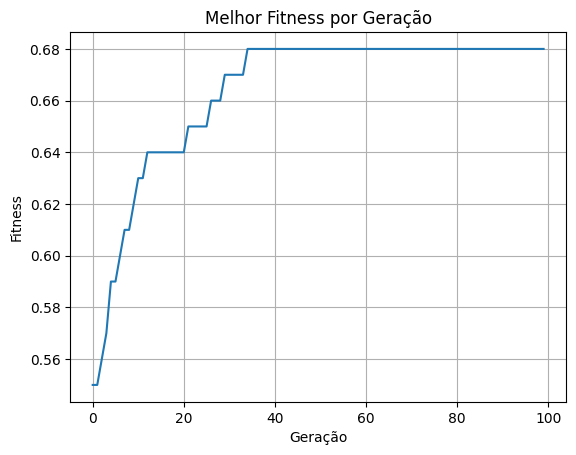

In [9]:
import pygad
import numpy as np
import matplotlib.pyplot as plt

# Lista para armazenar o melhor resultado de cada geração
best_fitness_values = []

# Função de aptidão (fitness function) com três parâmetros
def fitness_func(ga_instance, solution, solution_idx):
    return evaluate(dataset, dataset2, 'knn', embedding, top_n=10, repeat=5, mask=solution)

# Função de callback para salvar o melhor resultado de cada geração
def callback_generation(ga_instance):
    best_fitness_values.append(ga_instance.best_solution()[1])
    print(f"Generation {ga_instance.generations_completed}: Best Fitness = {ga_instance.best_solution()[1]}")

# Parâmetros do GA
ga_instance = pygad.GA(num_generations=100,
                       num_parents_mating=10,
                       fitness_func=fitness_func,
                       sol_per_pop=200,  # Tamanho da população
                       num_genes=1024,   # Cada indivíduo tem 1024 valores
                       gene_type=float,  # Genes são valores float
                       init_range_low=0.0,  # Valor mínimo para inicialização dos genes
                       init_range_high=1.0, # Valor máximo para inicialização dos genes
                       mutation_type="random",  # Tipo de mutação
                       random_mutation_min_val=0.0,  # Valor mínimo após mutação
                       random_mutation_max_val=1.0,  # Valor máximo após mutação
                       crossover_type="single_point",  # Tipo de crossover
                       on_generation=callback_generation)  # Callback para salvar o melhor resultado

# Executa o GA
ga_instance.run()

# Obtém a solução mais apta
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Melhor solução: {solution}")
print(f"Fitness da melhor solução: {solution_fitness}")

# Plota o gráfico do melhor fitness por geração
plt.plot(best_fitness_values)
plt.title("Melhor Fitness por Geração")
plt.xlabel("Geração")
plt.ylabel("Fitness")
plt.grid()
plt.show()


In [ ]:
# Continua o treinamento por mais 100 gerações
ga_instance.generations_completed = 0  # Resetando contador de gerações
ga_instance.num_generations = 100  # Mais 100 gerações
ga_instance.run()

# Obtém a solução mais apta após as 200 gerações (primeiras 100 + mais 100)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Melhor solução após 200 gerações: {solution}")
print(f"Fitness da melhor solução: {solution_fitness}")

# Plota o gráfico do melhor fitness por geração (incluindo as primeiras e as próximas 100 gerações)
plt.plot(best_fitness_values)
plt.title("Melhor Fitness por Geração ("+len(best_fitness_values)+" Gerações)")
plt.xlabel("Geração")
plt.ylabel("Fitness")
plt.grid()
plt.show()


In [13]:
file_path = os.path.join(folder_path, embedding+extra)
ga_instance.save(file_path)
save_dataset(best_fitness_values, embedding+extra+'_hist')

if mask[embedding] is None:
  print("Nova máscara salva, acurácia: ",solution_fitness)
  mask[embedding] = {'mask': solution.tolist(), 'accuracy': solution_fitness}
  save_dataset(mask,'mask')
elif mask[embedding]['accuracy'] < solution_fitness:
  print("Nova máscara salva, acurácia de ",solution_fitness, " maior que a anterior de ", mask[embedding]['accuracy'])
  mask[embedding] = {'mask': solution.tolist(), 'accuracy': solution_fitness}
  save_dataset(mask,'mask')
else:
  print("Máscara NÃO salva, acurácia de ",solution_fitness, " menor que a anterior de ", mask[embedding]['accuracy'])

Nova máscara salva, acurácia de  0.68  maior que a anterior de  0.49999999999999994
